In [507]:
import pandas as pd
import scipy as sc
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


/home/pavel/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [508]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
#train = train.sample(frac=0.1, random_state=42)

In [509]:
all_data = pd.concat([train, test])

In [510]:
ohe = OneHotEncoder(sparse=False)

dummy_features = ohe.fit_transform(all_data['item_id'].values.reshape(-1, 1))
dummy_features = pd.DataFrame(dummy_features, columns=['good = ' + str(x) for x in range(dummy_features.shape[1])])
all_data.index = dummy_features.index
new_all_data = pd.concat([all_data, dummy_features], axis=1)

In [511]:
dummy_features = ohe.fit_transform(new_all_data['week'].values.reshape(-1, 1))
dummy_features = pd.DataFrame(dummy_features, columns=['week = ' + str(x) for x in range(dummy_features.shape[1])])
new_all_data.index = dummy_features.index
new_all_data = pd.concat([new_all_data, dummy_features], axis=1).drop(['week'], axis=1)

In [512]:
dummy_features = ohe.fit_transform(new_all_data['year'].values.reshape(-1, 1))
dummy_features = pd.DataFrame(dummy_features, columns=['year = ' + str(x) for x in range(dummy_features.shape[1])])
new_all_data.index = dummy_features.index
new_all_data = pd.concat([new_all_data, dummy_features], axis=1).drop(['year'], axis=1)

In [513]:
new_train = new_all_data.drop(['item_id', 'Num'], axis=1)[:len(train)]
new_test = new_all_data.drop(['item_id', 'Num'], axis=1)[len(train):]
new_test = new_test.drop(['y'], axis=1)

In [514]:
X_train, y_train = new_train.drop(['y'], axis=1).as_matrix(), new_train['y'].values
X_test = new_test.as_matrix()

In [215]:
class sum_regressor:
    def __init__(self, bootstrap=True, b_coeff = 0.8):
        self.estimators = [KNeighborsRegressor(n_neighbors=5, p=2), 
                          RandomForestRegressor(n_estimators=130, max_depth=9), 
                          #GradientBoostingRegressor(n_estimators=120, max_depth=8, loss='lad'), 
                          ExtraTreesRegressor(n_estimators=70)]
        self.weights = [1, 1, 1]
        #self.weights = [2, 1, 7, 14]
        self.bootstrap = bootstrap
        self.b_coeff = b_coeff
    def fit(self, X, y):
        for est in self.estimators:
            if not self.bootstrap:
                est.fit(X, y)
            else: 
                b_index = np.random.randint(len(y), size=self.b_coeff * len(y))
                est.fit(X[b_index], y[b_index])

    def predict(self, X):
        predictions = np.zeros(len(X))
        for i in range(len(self.estimators)):
            predictions += self.weights[i]*self.estimators[i].predict(X)
        return predictions/np.sum(self.weights)
    
    def separate_predict(self, X):
        predictions = []
        for i in range(len(self.estimators)):
            predictions.append(self.estimators[i].predict(X))
        return predictions

In [515]:
est = new_est()
est.fit(X_train, y_train)
preds = est.predict(X_test)

In [516]:
sample_submission['y'] = preds
sample_submission.set_index('Num', inplace=True)
sample_submission.to_csv('submission.csv')

In [520]:
def test_estimator_onm(estimator):
    def do_stuff(X, y):
        tscv = TimeSeriesSplit(n_splits=5)
        score = []
        for train_index, test_index in tscv.split(X):
            estimator.fit(X[train_index], y[train_index])
            prediction = estimator.predict(X[test_index])
            score.append(SMAPE(y[test_index], prediction))
        print score
        return np.mean(score)
    return do_stuff(new_train.drop(['y'], axis=1).as_matrix(), new_train['y'].values)

def test_estimator_onm_transformed(estimator):
    def do_stuff(X, y):
        offset = 1000000000
        y_new = y + offset
        y_mean = np.mean(y_new)
        y_transformed = y_new/(2.0**0.5*y_mean)
        #y_transformed = y/offset
        tscv = TimeSeriesSplit(n_splits=3)
        score = []
        for train_index, test_index in tscv.split(X):
            estimator.fit(X[train_index], y_transformed[train_index])
            prediction = estimator.predict(X[test_index])
            prediction = prediction * (2.0**0.5*y_mean)**0.5 - offset
            #prediction = prediction*offset
            prediction = map(lambda x: 0 if x<0 else x, prediction)
            score.append(SMAPE(y[test_index], prediction))
        print score
        return np.mean(score)
    return do_stuff(new_train.drop(['y'], axis=1).as_matrix(), new_train['y'].values)

In [217]:
test_estimator_onm(GradientBoostingRegressor(loss='lad', n_estimators=70, max_depth=9))

[31.058982920800855, 28.800522842343913, 27.924290415587677]


29.261265392910815

In [224]:
test_estimator_onm(ExtraTreesRegressor(n_estimators=70))

[27.861377197140509, 26.703322442543541, 26.046501239356338]


26.870400293013461

In [302]:
test_estimator_onm(RandomForestRegressor(n_estimators=70))

[29.12109547594709, 28.362772028821286, 27.271926994623495]


28.251931499797291

In [521]:
class new_est:
    def __init__(self):
        self.est =ExtraTreesRegressor(n_estimators=70)
    
    def fit(self, X, y):
        self.est.fit(X, np.log(y))
        
    def predict(self, X):
        return np.exp(self.est.predict(X))
        

In [522]:
test_estimator_onm(new_est())

[30.55107659950329, 27.377445805690353, 21.683351162781982, 20.674164389416759, 33.420223977884397]


26.741252387055358

In [284]:
test_estimator_onm(RandomForestRegressor())

[31.026103329891157, 29.342177023481952, 28.469331322739418]


29.612537225370843

In [517]:
values = []
step = 0.0001
def sigmoid(x):
    return 1.0/(1 + np.exp(x))
#y_t = 1.0/(1 + np.exp(-0.1**9 *y))
#y_t = np.cos(1 + np.log(y)**0.5/10)
y_t = np.log(y)
for i in np.arange(np.min(y_t), np.max(y_t), step):
    a = y_t[ y_t >= i]
    values.append(len(a[a < i + step]))

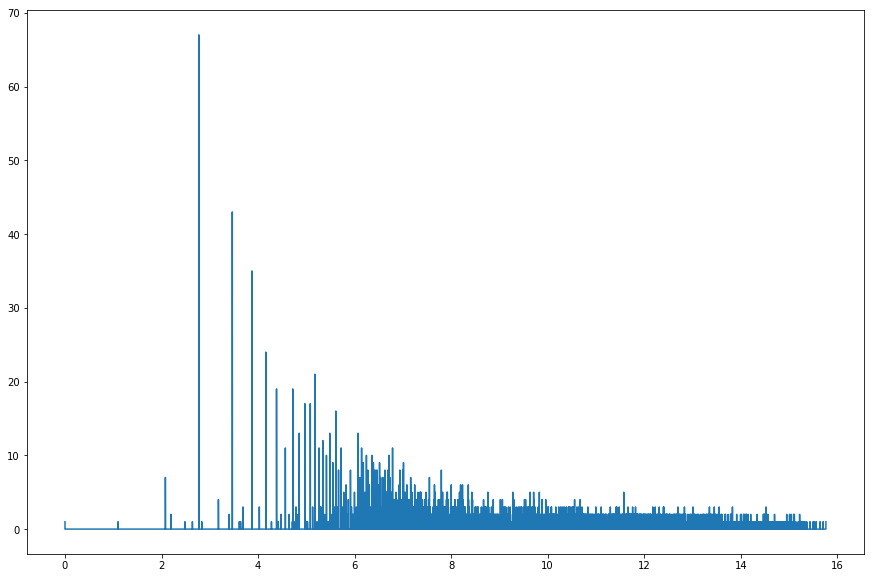

In [518]:
plt.plot(np.arange(np.min(y_t), np.max(y_t), step), values)
#plt.axis([0, 1000000, 0, 25])